<br><font size="6" face="Verdana" color='white'>BITCOIN PRICE PREDICTION</font><br>
<br><font size="4" face="Verdana" color='white'>by Reeve Chaitanya</font><br><br>

In [1]:
# Importing Necessary Libraies
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from time import strftime,localtime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
plt.style.use('dark_background')

<br>We extract the data using the Yahoo Finance API. The Data is Normalized and then divided into training and testing sets. The Prediction days are the days on which we base our prediction So, for example if the prediction days are 60 days, then the predicted price is for the 61st day. Furthermore, we create another set ‘real_data’ for predicting the Bitcoin Closing Price for the Next Day.
<br><br>

In [2]:
def prepare_dataset(prediction_days=60):
    
    # Intializing Scaler
    scaler = MinMaxScaler()
    
    # Intializing Currency Values
    crypto_currency = 'BTC'
    against_currency = 'INR'
    
    # Importing Training Data
    train_start = dt.datetime(2017,1,1)
    end = dt.datetime.now() # Present Day
    data = pdr.DataReader(f'{crypto_currency}-{against_currency}','yahoo',train_start,end)
    
    # Scaling Data
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
    
    # Splitting Training Data
    X_train = []
    Y_train = []
    for x in range(prediction_days,len(scaled_data)):
        X_train.append(scaled_data[x-prediction_days:x,0])
        Y_train.append(scaled_data[x,0])
    
    # Converting to Numpy Array
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    
    # Reshaping Training Data
    X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
    
    # Test Data
    test_start = dt.datetime(2020,1,1)
    test_data = pdr.DataReader(f'{crypto_currency}-{against_currency}','yahoo',test_start,end)
    
    # Total Data
    total_data = pd.concat((data['Close'],test_data['Close']),axis=0)
    
    # Inputs for Testing
    model_inputs = total_data[len(total_data)-len(test_data)-prediction_days:].values
    model_inputs = model_inputs.reshape(-1,1) # Reshaping
    model_inputs = scaler.fit_transform(model_inputs) # Scaling
    
    X_test = []
    for x in range(prediction_days,len(model_inputs)):
        X_test.append(model_inputs[x-prediction_days:x,0])
        
    # Converting to Numpy Array
    X_test = np.array(X_test)
    
    # Reshaping Test Data
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    
    # Data for Prediction for Tomorrow
    real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs) + 1,0]]
    real_data = np.array(real_data) # Converting to Numpy array
    real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1)) #Reshaping
    
    Y_test = test_data['Close'].values
    
    return X_train, X_test, Y_train, Y_test, scaler, real_data

<br>
The model is trained using Tensorflow and Keras over it. The Model consists of an input layer, 3 LSTM layers, a dense layer and an output layer . It uses Dropout with a rate of 25% to combat overfitting during training. Also, it uses Mean Squared Error as a loss function and Adam optimizer.
<br><br>

In [3]:
def build_model():
    model = Sequential()
    model.add(LSTM(units = 70, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.25)) 
    model.add(LSTM(units = 70, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.25)) 
    model.add(LSTM(units = 70, activation = 'relu'))
    model.add(Dropout(0.25)) 
    model.add(Dense(units =1))
    model.summary()
    return model

In [4]:
# Preparing Datasets
X_train, X_test, Y_train, Y_test, scaler, real_data = prepare_dataset()

# Building Model
model = build_model()

# Compiling Model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Training Model
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 70)            20160     
                                                                 
 dropout (Dropout)           (None, 60, 70)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 70)            39480     
                                                                 
 dropout_1 (Dropout)         (None, 60, 70)            0         
                                                                 
 lstm_2 (LSTM)               (None, 70)                39480     
                                                                 
 dropout_2 (Dropout)         (None, 70)                0         
                                                                 
 dense (Dense)               (None, 1)                 7

In [5]:
# Predicting
Y_pred = model.predict(X_test)
Y_pred = scaler.inverse_transform(Y_pred)

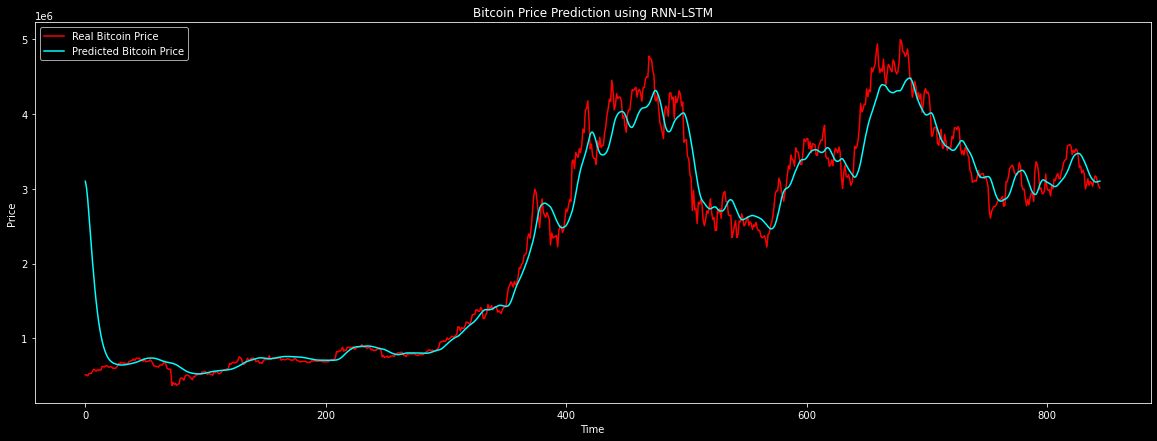

In [6]:
# Visualizing Results
plt.figure(figsize=(20,7))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'cyan', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [7]:
# Predicting Next Day
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

In [8]:
print(f"Bitcoin Close Value Prediction for {(dt.datetime.now()+dt.timedelta(days=1)).strftime('%d %B %Y')} : Rs. {round(float(prediction[0][0]),2)}")

Bitcoin Close Value Prediction for 24 April 2022 : Rs. 3100773.0
